In [5]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import os

os.environ['CUDA_VISIBLE_DEVICES']=str(1)

import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import csv
from keras.models import Sequential, Model
from keras.layers import Conv2D, ConvLSTM2D, Dense, MaxPooling2D, Dropout, Flatten, Reshape, merge, Input
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from generator import generator
from car_models import *
from sklearn.utils import shuffle
from tqdm import tqdm_notebook


from get_images import get_images

datadirs=['/notebooks/udacity/new_training/map1_backward/',
                 '/notebooks/udacity/new_training/map1_forward/',
                 '/notebooks/udacity/new_training/map1_recovery_backward/',
                 '/notebooks/udacity/new_training/map1_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_forward/',
                 '/notebooks/udacity/new_training/map2_backward/',
                 '/notebooks/udacity/new_training/map2_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_recovery_backward/',
                   '/notebooks/udacity/new_training/map1_error_correction/',
                   '/notebooks/udacity/new_training/map2_error_correction/'
         ]

images=get_images(datadirs,0.08)
image_names_full, y_data_full = images.img.values, images.real.values

size=(40,80)

def preprocessing_resize(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)

def proc_img(img): # input is 160x320x3
    img = img[59:138:2, 0:-1:2, :] # select vertical region and take each second pixel to reduce image dimensions
    img = (img / 127.5) - 1.0 # normalize colors from 0-255 to -1.0 to 1.0
    return img # return 40x160x3 image

names_train, names_valid, y_train, y_valid = train_test_split(image_names_full, y_data_full, test_size=0.02,\
                            random_state=0)

names_valid, names_test, y_valid, y_test = train_test_split(names_valid, y_valid, test_size=0.5,\
                                        random_state=0)

inverse_train=[0 for i in y_train]+[1 for i in y_train]


names_train=  np.concatenate([names_train,names_train])
y_train    =   np.concatenate([y_train,y_train])

names_train,y_train,inverse_train=shuffle(names_train,y_train,inverse_train) 





In [33]:
import os
import pickle


def train_model(get_model, preprocessing, name, optimizer = 'adam',nb_epoch=100):
    #print ('Training model %s' % name)
    
    model=get_model()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
    
    if not os.path.exists('results/logs_%s'%name):
        os.mkdir('results/logs_%s'%name)
    
    
    checkpoint = ModelCheckpoint("results/model_%s_{epoch:02d}.h5" % name, monitor='val_mean_squared_error', verbose=1,
                              save_best_only=False, mode='min')
    early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                               min_delta=0.001, patience=3,
                                verbose=False, mode='min')

    history = History()

    tb=TensorBoard(log_dir='results/logs_%s'%name, histogram_freq=0, write_graph=True, write_images=False)
    
    train_gen=generator2(names_train, y_train, batch_size=64, preprocessing=preprocessing, inverse=inverse_train)
    valid_gen=generator(names_valid, y_valid, batch_size=64, preprocessing=preprocessing)
    test_gen= generator (names_test, y_test, batch_size=64,preprocessing=preprocessing)

    q=model.fit_generator(train_gen, \
                    samples_per_epoch=len(names_train),\
                    nb_epoch=nb_epoch,\
                    verbose=False,\
                    validation_data=valid_gen, \
                    nb_val_samples=len(names_valid),\
                    callbacks=[checkpoint, early_stop,history,tb,TQDMNotebookCallback()]\
                   )
    
    f=open('results/history_%s.pk1' % name,'wb')
    pickle.dump(history.history,f,-1)
    f.close()
    
    model.load_weights("results/model_%s.h5" % name)
    
    res=model.evaluate_generator(test_gen,val_samples=len(names_test))[0]
    return q,res

train_model(modified_vgg, proc_img, 'modified_vgg', optimizer=Adam(lr=0.0001), nb_epoch=10)

In [29]:
grid=[{'get_model':modified_lenet,'preprocessing':lambda x:x,       'optimizer':'adam','name':'modified_lenet'},\
      {'get_model':modified_vgg,  'preprocessing': proc_img,        'optimizer':Adam(lr=0.0001),'name':'modified_vgg'},\
      {'get_model':nvidia_net,    'preprocessing':preprocessing_yuv,'optimizer':'adam','name':'nvidia_net'},\
      {'get_model':inception,     'preprocessing':lambda x:x,       'optimizer':'adam','name':'inception'},\
      {'get_model':vgg16,         'preprocessing':lambda x:x,       'optimizer':'adam','name':'vgg16'} ]

In [32]:
%%sh

rm -r results/
mkdir results

In [ ]:
results=[train_model(**a) for a in tqdm_notebook(grid[2:], desc='models')]

The installed widget Javascript is the wrong version.


Instructions for updating:
Please switch to tf.summary.merge_all.


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to results/model_nvidia_net_00.h5


The installed widget Javascript is the wrong version.


Epoch 00001: saving model to results/model_nvidia_net_01.h5


The installed widget Javascript is the wrong version.


Epoch 00008: saving model to results/model_nvidia_net_08.h5


The installed widget Javascript is the wrong version.


In [59]:
h=[
"results/history_modified_lenet.pk1",
"results/history_modified_vgg.pk1",
"results/history_nvidia_net.pk1",
"results/history_vgg16.pk1"
]

data=[]

for a in h:
    with open(a,'rb') as f:
        data.append(pickle.load(f))

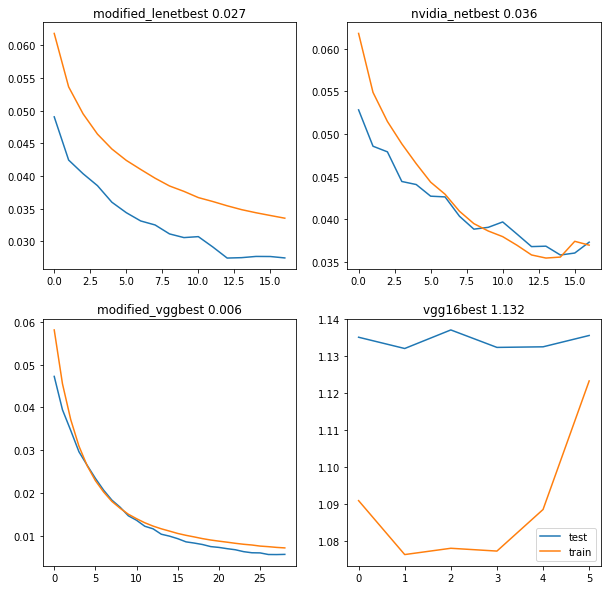

best is modified_vgg


In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

for q in range(4):
    i,j = q % 2, int (q/2)
    ax[i][j].set_title(h[q].split('/')[-1].split('.')[0].replace('history_','') + 'best %.3f' \
                       % min(data[q]['val_mean_squared_error']))
    ax[i][j].plot(data[q]['val_mean_squared_error'],label='test')
    ax[i][j].plot(data[q]['mean_squared_error'],label='train')
    
plt.savefig('images/fitting.png')    
    
plt.legend()
plt.show()

best=np.argmin([min(h['val_mean_squared_error']) for h in data])

print ('best is %s' % h[best].split('/')[-1].split('.')[0].replace('history_',''))

results/history_modified_lenet.pk1
results/history_modified_vgg.pk1
results/history_nvidia_net.pk1


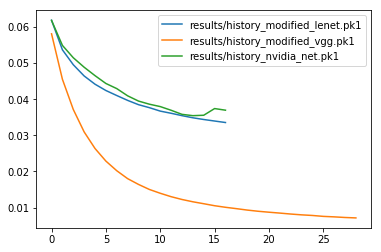

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

for name, q in zip(h,data):
    print (name)
    plt.plot(q['mean_squared_error'],label=name)
    
plt.legend()
plt.show()

In [72]:
%%sh

mkdir images

In [74]:
model=modified_vgg()

In [75]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 40, 160, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_46 (Convolution2D) (None, 40, 160, 3)    12          input_4[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_26 (MaxPooling2D)   (None, 20, 80, 3)     0           convolution2d_46[0][0]           
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 20, 80, 32)    896         maxpooling2d_26[0][0]            
___________________________________________________________________________________________

In [76]:
len(images)

275616

In [82]:
from keras.utils.visualize_util import plot_model
#plot_model(model, to_file='images/model.png')

ImportError: No module named 'pydot'